In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
import astropy.coordinates as coord
from matplotlib.colors import LogNorm

In [2]:
%store -r prediction_E_64pix_9epoch_10batch_foregrounds
%store -r prediction_B_64pix_9epoch_10batch_foregrounds
%store -r prediction_EB_64pix_9epoch_10batch_foregrounds
%store -r prediction_QU_64pix_9epoch_10batch_foregrounds
%store -r prediction_P_64pix_9epoch_10batch_foregrounds

##### **Select the objects from the Observation catalogue**

In [3]:
%store -r table_PS_obs

In [4]:
selected_brightest = table_PS_obs.iloc[[4, 99, 499]]

In [5]:
%store -r lon
%store -r lat
%store -r xsize
%store -r reso

In [6]:
lon_PS_obs = selected_brightest['lon(°)']
lat_PS_obs = selected_brightest['lat(°)']

In [7]:
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)
lon_PS_obs_rad = np.radians(lon_PS_obs.values)
lat_PS_obs_rad = np.radians(lat_PS_obs.values)

In [8]:
#reso is in arcmin
def convert_lonlat_to_patch_position(lon_PS, lat_PS, lon_PS_rad, lat_PS_rad, lon = lon, lat = lat, xsize = xsize, reso = reso):
    patch_positions = []

    for lon_PS_rad, lat_PS_rad, lon_PS, lat_PS in zip(lon_PS_rad, lat_PS_rad, lon_PS, lat_PS):
        
        patch_index = np.argmin(coord.angular_separation(lon_PS_rad, lat_PS_rad, lon_rad, lat_rad))

        patch_lon, patch_lat = lon[patch_index], lat[patch_index]

        proj = hp.projector.GnomonicProj(ysize=xsize, xsize=xsize, rot=(patch_lon, patch_lat, 0), reso=reso)
        x, y = proj.ang2xy(lon_PS, lat_PS, lonlat=True)
        i,j = proj.xy2ij(x = x, y = y)
        

        patch_positions.append((patch_index, i, j))

    return patch_positions

In [9]:
selected_ij = convert_lonlat_to_patch_position(lon_PS_obs, lat_PS_obs, lon_PS_obs_rad, lat_PS_obs_rad)

In [10]:
patch_numbers = [item[0] for item in selected_ij]
peak_patch_x = [item[2] for item in selected_ij]
peak_patch_y = [item[1] for item in selected_ij]

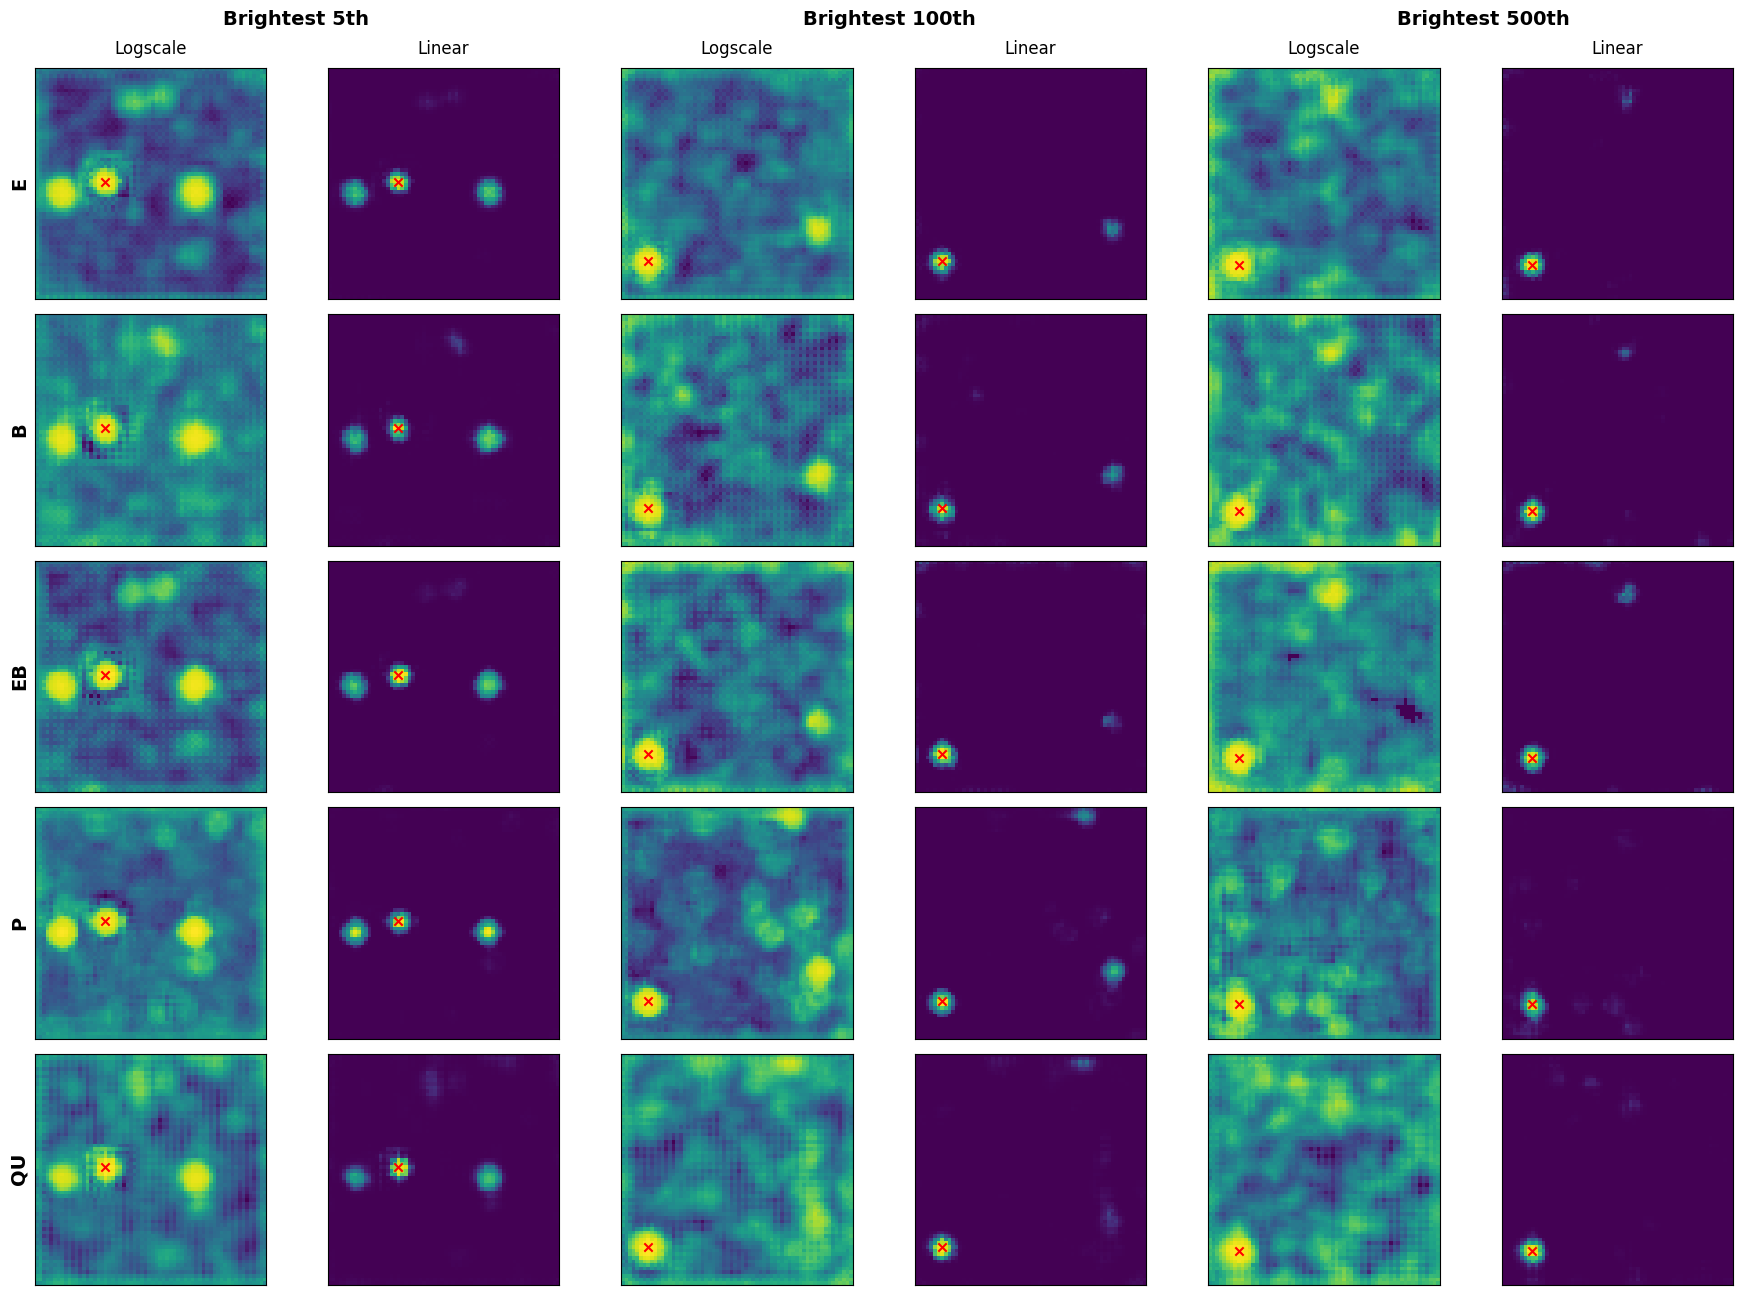

In [12]:
fig, axs = plt.subplots(5, 6, figsize=(18, 15))

row_names = ['E', 'B', 'EB', 'P', 'QU']
col_names = ['Brightest 5th', 'Brightest 100th', 'Brightest 500th']

fig.text(0.18, 0.95, col_names[0], ha='center', fontsize=14, fontweight='bold')
fig.text(0.51, 0.95, col_names[1], ha='center', fontsize=14, fontweight='bold')
fig.text(0.84, 0.95, col_names[2], ha='center', fontsize=14, fontweight='bold')

for i, row in enumerate(axs):
    row[0].set_ylabel(row_names[i], fontsize=14, fontweight='bold')  
    for j in range(0, 6, 2):
        ax1 = row[j]
        ax2 = row[j + 1]

        patch_num = patch_numbers[j // 2]
        peak_x = peak_patch_x[j // 2]
        peak_y = peak_patch_y[j // 2]

        if i == 0:
            prediction_array = prediction_E_64pix_9epoch_10batch_foregrounds
        elif i == 1:
            prediction_array = prediction_B_64pix_9epoch_10batch_foregrounds
        elif i == 2:
            prediction_array = prediction_EB_64pix_9epoch_10batch_foregrounds
        elif i == 3:
            prediction_array = prediction_P_64pix_9epoch_10batch_foregrounds
        elif i == 4:
            prediction_array = prediction_QU_64pix_9epoch_10batch_foregrounds

        ax1.imshow(prediction_array[patch_num], norm=LogNorm())
        ax1.scatter(peak_x, peak_y, marker='x', c = 'red')
        ax2.imshow(prediction_array[patch_num])
        ax2.scatter(peak_x, peak_y, marker='x', c = 'red')

        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])

for j in range(0, 6, 2):
    axs[0, j].set_title('Logscale', loc='center', pad=10)
    axs[0, j + 1].set_title('Linear', loc='center', pad=10)

fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig('Patch_prediction_comparison_foregrounds.pdf')
plt.show()
